### imports

In [1]:
import pickle
import numpy as np
import scipy
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage.segmentation import watershed
from skimage import filters
import seaborn as sns
from scipy import ndimage as ndi
from skimage import *
import cv2
import anndata as ad
import pandas as pd
import scanpy as sc
# import seaborn as sns
# import pandas as pd

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### settings

In [2]:
sns.set_style('white')
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 2}

# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 2})

import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title






### functions

In [6]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import gaussian


def EB(test_tissue):
    #     test_tissue = 'R1'
    image = Segment_im_dict[test_tissue]
    image = gaussian(image)
    edges = canny(image / image.max())
    fill_cells = ndi.binary_fill_holes(edges).astype("int")
    segmented_cells, _ = ndi.label(fill_cells)
    return segmented_cells


def WS_edt(test_tissue, init_class, min_dist=5):
    #     test_tissue = 'A549'
    image = Segment_im_dict[test_tissue]
    thresholds = filters.threshold_multiotsu(image, classes=init_class)
    cells = image > thresholds[-1]
    distance = ndi.distance_transform_edt(cells)
    # distance = image

    local_max_coords = feature.peak_local_max(distance, min_distance=min_dist)
    local_max_mask = np.zeros(distance.shape, dtype=bool)
    local_max_mask[tuple(local_max_coords.T)] = True
    markers = measure.label(local_max_mask)

    segmented_cells = watershed(-distance, markers, mask=cells)

    #     plt.imshow(color.label2rgb(segmented_cells, bg_label=0))

    #     plt.show()
    return segmented_cells


def WS_grad(test_tissue, init_class):
    image = Segment_im_dict[test_tissue]
    elevation_map = sobel(image)
    thresholds = filters.threshold_multiotsu(image, classes=init_class)
    markers = np.zeros_like(image)
    #     find sure bg and fg
    markers[image > thresholds[-1]] = 2
    markers[image < thresholds[0]] = 1

    segmentation = watershed(elevation_map, markers) - 1
    segmented_cells, _ = ndi.label(segmentation)

    #     plt.imshow(color.label2rgb(segmented_cells, bg_label=0))
    #     plt.show()
    return segmented_cells


from PIL import Image
import numpy as np


def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)


def get_MIBI_adata(patient_no):
    # patient_no = 16

    tiff_path = "/home/yzy/PUBDT/st/MIBI/BC/tiff/"
    seg_path = "/home/yzy/PUBDT/st/MIBI/BC/segmentation_mask/"
    h5ad_path = "/home/yzy/PUBDT/st/MIBI/BC/h5ad/"
    cur_tif_file = tiff_path + "TA459_multipleCores2_Run-4_Point{0}.tiff".format(patient_no)
    tiff = read_tiff(cur_tif_file)

    seg_file = seg_path + "TA459_multipleCores2_Run-4_Point{0}_Overlay.png".format(patient_no)
    img = cv2.imread(seg_file)

    img_0 = img[:, :, 0]

    import skimage
    from skimage.viewer.viewers import ImageViewer

    mask = img_0 > 200

    labeled_image = skimage.measure.label(mask, connectivity=2, return_num=True)[0]

    plt.imshow(img)
    plt.title("original")
    plt.show()
    plt.imshow(mask)
    plt.title("binary mask")
    plt.show()
    plt.imshow(labeled_image)
    plt.title("labeled image")
    plt.show()

    var_list = [
        "Au",
        "Background",
        "Beta catenin",
        "Ca",
        "CD11b",
        "CD11c",
        "CD138",
        "CD16",
        "CD20",
        "CD209",
        "CD3",
        "CD31",
        "CD4",
        "CD45",
        "CD45RO",
        "CD56",
        "CD63",
        "CD68",
        "CD8",
        "dsDNA",
        "EGFR",
        "Fe",
        "FoxP3",
        "H3K27Me3",
        "H3K9ac",
        "HLA-DR",
        "HLA_Class_1",
        "IDO",
        "Keratin17",
        "Keratin6",
        "Ki67",
        "Lag3",
        "MPO",
        "Na",
        "P",
        "p53",
        "Pan-Keratin",
        "PD-L1",
        "PD1",
        "phospho-S6",
        "Si",
        "SMA",
        "Ta",
        "Vimentin",
    ]

    cell_num = labeled_image.max()
    cell_pixel_dict = {}
    cell_pos_dict = {}
    # key：cellidx（1开始）；value：numpy matrix，num_pixels*num_vars
    for i in range(labeled_image.shape[0]):
        for j in range(labeled_image.shape[1]):
            cur_label = labeled_image[i, j]
            cur_pixel_profile = tiff[:, i, j]
            if cur_label == 0:
                continue
            if cur_label not in cell_pixel_dict:
                cell_pixel_dict[cur_label] = [cur_pixel_profile]
                cell_pos_dict[cur_label] = [np.array([i, j])]
            else:
                cell_pixel_dict[cur_label].append(cur_pixel_profile)
                cell_pos_dict[cur_label].append(np.array([i, j]))

    for cell_idx in cell_pixel_dict.keys():
        cell_pixel_dict[cell_idx] = np.vstack(cell_pixel_dict[cell_idx])
        cell_pos_dict[cell_idx] = np.vstack(cell_pos_dict[cell_idx])

    X_mat = []
    spatial_mat = []
    cell_size_mat = []
    for cell_idx in cell_pixel_dict:
        cur_X = np.mean(cell_pixel_dict[cell_idx], axis=0)
        cur_spatial = np.mean(cell_pos_dict[cell_idx], axis=0)
        cur_cell_size = cell_pixel_dict[cell_idx].shape[0]
        X_mat.append(cur_X)
        spatial_mat.append(cur_spatial)
        cell_size_mat.append(cur_cell_size)
    X_mat = np.vstack(X_mat)
    spatial_mat = np.vstack(spatial_mat)
    cell_size_mat = np.array(cell_size_mat)

    X_mat = np.arcsinh(X_mat)

    adata = ad.AnnData(X=X_mat, var=pd.DataFrame(index=var_list))

    adata.obsm["spatial"] = spatial_mat
    adata.obs["cell_size"] = cell_size_mat

    sc.pl.embedding(adata, basis="spatial", color=["cell_size", "SMA", "Beta catenin", "CD11b"], ncols=2, s=50)
    return adata, labeled_image, tiff, var_list



/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


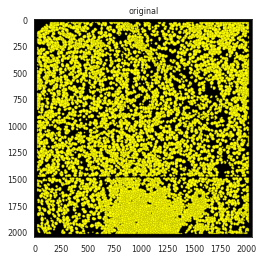

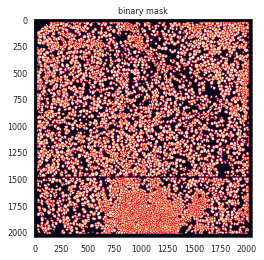

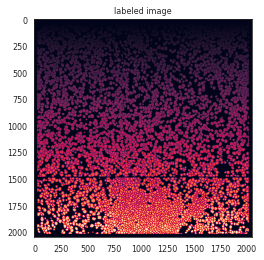

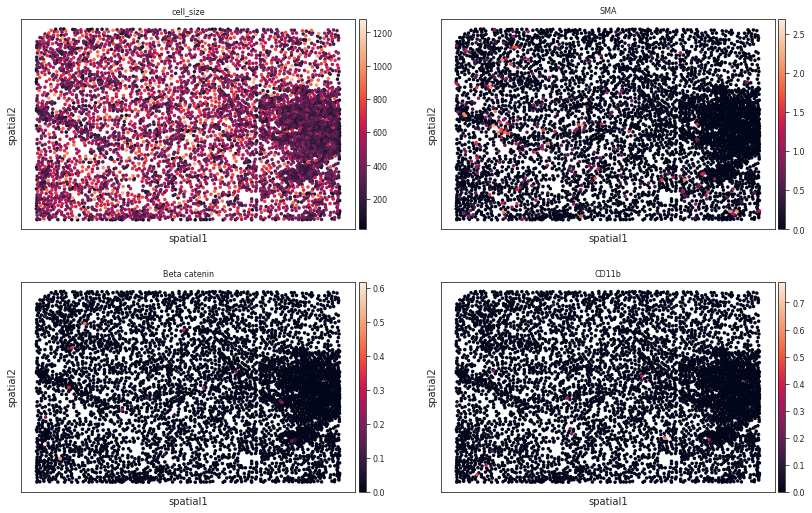

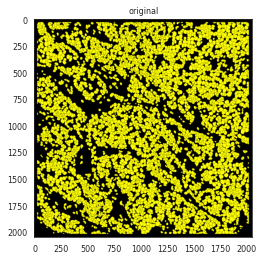

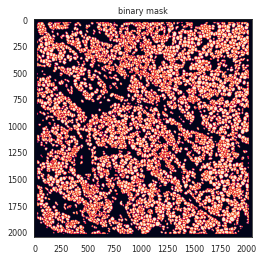

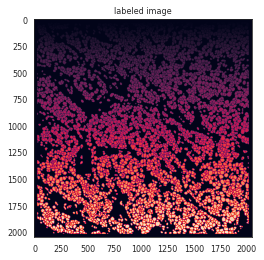

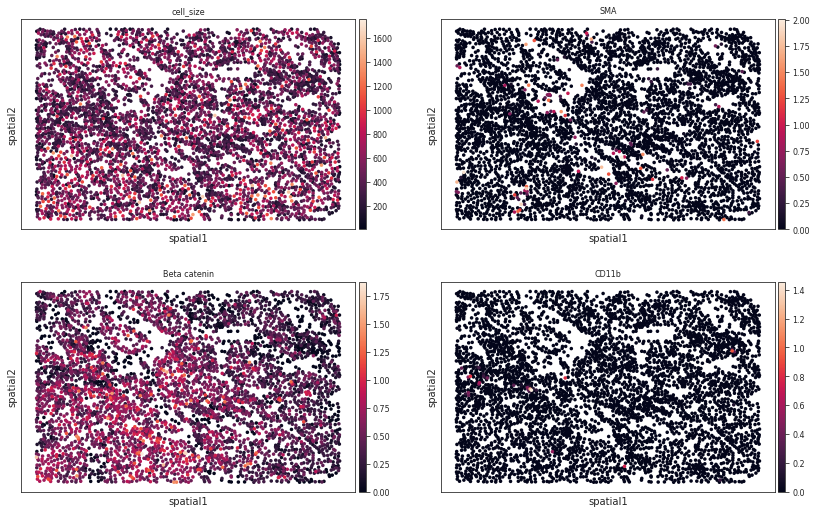

In [5]:
p_list = [1,24]
Segment_gt_dict = {}
Segment_im_dict = {}
for p in p_list:
    _,labeled_image,tiff,var_list = get_MIBI_adata(p)
    gt_seg = labeled_image
    im_seg = tiff[np.where(np.array(var_list)=='dsDNA')[0],:,:][0,:]
    Segment_gt_dict['P'+str(p)] = gt_seg
    Segment_im_dict['P'+str(p)] = im_seg
    
    


In [8]:
EB_mask_dict = {}


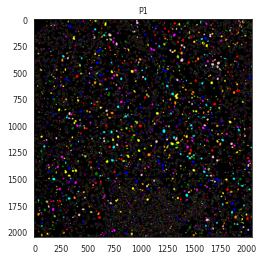

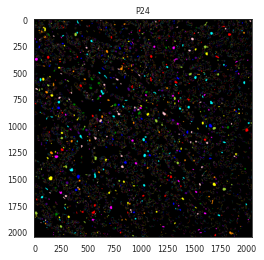

In [9]:
tissue_list = Segment_im_dict.keys()
for test_tissue in tissue_list:
    
    
    
    img = Segment_im_dict[test_tissue]
    EB_rst = EB(test_tissue)

    EB_mask_dict[test_tissue]=EB_rst


    plt.imshow(color.label2rgb(EB_rst,bg_label=0))
    plt.title('{0}'.format(test_tissue))
    plt.show()

In [11]:
with open('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation/Segment_EB.pickle', 'wb') as handle:
    pickle.dump(EB_mask_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    